# 迷你项目：动态规划

在此 notebook 中，你将自己编写很多经典动态规划算法的实现。

虽然我们提供了一些起始代码，但是你可以删掉这些提示并从头编写代码。

### 第 0 部分：探索 FrozenLakeEnv

请使用以下代码单元格创建 [FrozenLake](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) 环境的实例。

In [1]:
from frozenlake import FrozenLakeEnv
%matplotlib inline
env = FrozenLakeEnv()

智能体将会在 $4 \times 4$ 网格世界中移动，状态编号如下所示：

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

智能体可以执行 4 个潜在动作：

In [2]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

因此，$\mathcal{S}^+ = \{0, 1, \ldots, 15\}$ 以及 $\mathcal{A} = \{0, 1, 2, 3\}$。请通过运行以下代码单元格验证这一点。

In [3]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


动态规划假设智能体完全了解 MDP。我们已经修改了 `frozenlake.py` 文件以使智能体能够访问一步动态特性。 

请执行以下代码单元格以返回特定状态和动作对应的一步动态特性。具体而言，当智能体在网格世界中以状态 1 向左移动时，`env.P[1][0]` 会返回每个潜在奖励的概率和下一个状态。

In [4]:
env.P[6]

{0: [(0.3333333333333333, 2, 0.0, False),
  (0.3333333333333333, 5, 0.0, True),
  (0.3333333333333333, 10, 0.0, False)],
 1: [(0.3333333333333333, 5, 0.0, True),
  (0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 7, 0.0, True)],
 2: [(0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 7, 0.0, True),
  (0.3333333333333333, 2, 0.0, False)],
 3: [(0.3333333333333333, 7, 0.0, True),
  (0.3333333333333333, 2, 0.0, False),
  (0.3333333333333333, 5, 0.0, True)]}

每个条目的格式如下所示



prob, next_state, reward, done

其中：
- `prob` 详细说明了相应的  (`next_state`, `reward`) 对的条件概率，以及
- 如果 `next_state` 是终止状态，则 `done` 是 `True` ，否则是 `False`。

因此，我们可以按照以下方式解析 `env.P[1][0]`：
$$
\mathbb{P}(S_{t+1}=s',R_{t+1}=r|S_t=1,A_t=0) = \begin{cases}
               \frac{1}{3} \text{ if } s'=1, r=0\\
               \frac{1}{3} \text{ if } s'=0, r=0\\
               \frac{1}{3} \text{ if } s'=5, r=0\\
               0 \text{ else}
            \end{cases}
$$

你可以随意更改上述代码单元格，以探索在其他（状态、动作）对下环境的行为是怎样的。

### 第 1 部分：迭代策略评估

在此部分，你将自己编写迭代策略评估的实现。

你的算法应该有四个**输入**参数：
- `env`：这是 OpenAI Gym 环境的实例，其中 `env.P` 会返回一步动态特性。
- `policy`：这是一个二维 numpy 数组，其中 `policy.shape[0]` 等于状态数量 (`env.nS`) ， `policy.shape[1]` 等于动作数量 (`env.nA`) 。`policy[s][a]`  返回智能体在状态 `s` 时根据该策略选择动作 `a` 的概率。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。
- `theta`：这是一个非常小的正数，用于判断估算值是否足够地收敛于真值函数 (默认值为：`1e-8`）。

该算法会返回以下**输出结果**：
- `V`：这是一个一维numpy数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 在输入策略下的估算值。

请完成以下代码单元格中的函数。

In [5]:
import numpy as np

def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)  #第一次估值设为0
    ## TODO: complete the function  
    while True:
        delta = 0  #变化量
        for s in range(env.nS):  #循环每个状态s
            Vs = 0    #设置 Vs
            for a,action_prob in enumerate(policy[s]):  #遍历s状态下的所有动作和该动作的概率
                for prob, next_state, reward, done in env.P[s][a]:  #遍历s状态和a动作下的一步动态特性
                    Vs += action_prob * prob * (reward + gamma*V[next_state])  #更新Vs
            delta = max(delta,np.abs(V[s]-Vs)) #每次循环后，保存最大的变化量，循环结束后可得变化量最大的数
            V[s]=Vs  #赋值新的值函数，然后进入下一个s状态的更新
        if delta < theta:  #如果变化量为小于theta，则表示，已找到真正的值函数
                break
            
    return V

我们将评估等概率随机策略  $\pi$，其中对于所有 $s\in\mathcal{S}$ 和 $a\in\mathcal{A}(s)$ ，$\pi(a|s) = \frac{1}{|\mathcal{A}(s)|}$。  

请使用以下代码单元格在变量 `random_policy`中指定该策略。

In [6]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
for i ,b in enumerate(random_policy[10]):
    print(i,",",b)

0 , 0.25
1 , 0.25
2 , 0.25
3 , 0.25


运行下个代码单元格以评估等概率随机策略并可视化输出结果。状态值函数已调整形状，以匹配网格世界的形状。

D:\ProgramData\Anaconda3\envs\openai-gym\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


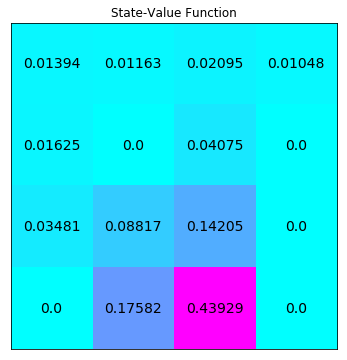

In [7]:
from plot_utils import plot_values

# evaluate the policy 
V = policy_evaluation(env, random_policy)

plot_values(V)

运行以下代码单元格以测试你的函数。如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！ 

**注意：**为了确保结果准确，确保你的 `policy_evaluation` 函数满足上文列出的要求（具有四个输入、一个输出，并且没有更改输入参数的默认值）。

In [8]:
import check_test

check_test.run_check('policy_evaluation_check', policy_evaluation)

**<span style="color: green;">PASSED</span>**

### 第 2 部分：通过 $v_\pi$ 获取 $q_\pi$

在此部分，你将编写一个函数，该函数的输入是状态值函数估值以及一些状态 $s\in\mathcal{S}$。它会返回输入状态 $s\in\mathcal{S}$ 对应的**动作值函数中的行**。即你的函数应同时接受输入 $v_\pi$ 和 $s$，并针对所有 $a\in\mathcal{A}(s)$ 返回 $q_\pi(s,a)$。

你的算法应该有四个**输入**参数：
- `env`：这是 OpenAI Gym 环境的实例，其中 `env.P` 会返回一步动态特性。
- `V`：这是一个一维 numpy 数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 的估值。
- `s`：这是环境中的状态对应的整数。它应该是在 `0` 到 `(env.nS)-1`（含）之间的值。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下**输出结果**：

- `q`：这是一个一维 numpy 数组，其中 `q.shape[0]` 等于动作数量 (`env.nA`)。`q[a]` 包含状态 `s` 和动作 `a` 的（估算）值。

请完成以下代码单元格中的函数。

In [9]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    ## TODO: complete the function
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]: 
            q[a] += prob * (reward + gamma*V[next_state])
  
    return q

请运行以下代码单元格以输出上述状态值函数对应的动作值函数。

In [20]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
    print(Q[s])
print("Action-Value Function:")
print(Q)

[0.0147094  0.01393978 0.01393978 0.01317015]
[0.00852356 0.01163091 0.0108613  0.01550788]
[0.02444514 0.02095298 0.02406033 0.01435346]
[0.01047649 0.01047649 0.00698432 0.01396865]
[0.02166487 0.01701828 0.01624865 0.01006281]
[0. 0. 0. 0.]
[0.05433538 0.04735105 0.05433538 0.00698432]
[0. 0. 0. 0.]
[0.01701828 0.04099204 0.03480619 0.04640826]
[0.07020885 0.11755991 0.10595784 0.05895312]
[0.18940421 0.17582037 0.16001424 0.04297382]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0.08799677 0.20503718 0.23442716 0.17582037]
[0.25238823 0.53837051 0.52711478 0.43929118]
[0. 0. 0. 0.]
Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0

运行以下代码单元格以测试你的函数。如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！ 

**注意：**为了确保结果准确，确保 `q_from_v` 函数满足上文列出的要求（具有四个输入、一个输出，并且没有更改输入参数的默认值）。

In [11]:
check_test.run_check('q_from_v_check', q_from_v)

**<span style="color: green;">PASSED</span>**

### 第 3 部分：策略改进

在此部分，你将自己编写策略改进实现。 

你的算法应该有三个**输入**参数：
- `env`：这是 OpenAI Gym 环境的实例，其中 `env.P` 会返回一步动态特性。
- `V`：这是一个一维 numpy 数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 的估值。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下**输出结果**：

- `policy`：这是一个二维 numpy 数组，其中 `policy.shape[0]` 等于状态数量 (`env.nS`) ， `policy.shape[1]` 等于动作数量 (`env.nA`) 。`policy[s][a]`  返回智能体在状态 `s` 时根据该策略选择动作 `a` 的概率。

请完成以下代码单元格中的函数。建议你使用你在上文实现的 `q_from_v` 函数。

In [21]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    
    ## TODO: complete the function
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        policy[s][np.argmax(q)] = 1
    return policy

运行以下代码单元格以测试你的函数。如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！ 

**注意：**为了确保结果准确，确保 `policy_improvement` 函数满足上文列出的要求（具有三个输入、一个输出，并且没有更改输入参数的默认值）。

在继续转到该 notebook 的下个部分之前，强烈建议你参阅 **Dynamic_Programming_Solution.ipynb** 中的解决方案。该函数有很多正确的实现方式！

In [22]:
check_test.run_check('policy_improvement_check', policy_improvement)

**<span style="color: green;">PASSED</span>**

### 第 4 部分：策略迭代

在此部分，你将自己编写策略迭代的实现。该算法会返回最优策略，以及相应的状态值函数。

你的算法应该有三个**输入**参数：

- `env`：这是 OpenAI Gym 环境的实例，其中 `env.P` 会返回一步动态特性。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。
- `theta`：这是一个非常小的正数，用于判断策略评估步骤是否足够地收敛于真值函数 (默认值为：`1e-8`）。

该算法会返回以下**输出结果**：

- `policy`：这是一个二维 numpy 数组，其中 `policy.shape[0]` 等于状态数量 (`env.nS`) ， `policy.shape[1]` 等于动作数量 (`env.nA`) 。`policy[s][a]`  返回智能体在状态 `s` 时根据该策略选择动作 `a` 的概率。
- `V`：这是一个一维 numpy 数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 的估值。

请完成以下代码单元格中的函数。强烈建议你使用你在上文实现的 `policy_evaluation` 和 `policy_improvement` 函数。

In [15]:
import copy

def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    ## TODO: complete the function
  
    return policy, V

运行下个代码单元格以解决该 MDP 并可视化输出结果。最优状态值函数已调整形状，以匹配网格世界的形状。

**将该最优状态值函数与此 notebook 第 1 部分的状态值函数进行比较**。_最优状态值函数一直都大于或等于等概率随机策略的状态值函数吗？_


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[ 0.05883759  0.05575911  0.05575911  0.0526806 ]
 [ 0.03409424  0.04652366  0.04344518  0.06203154]
 [ 0.09778056  0.08381191  0.09624132  0.05741383]
 [ 0.04190594  0.04190594  0.02793729  0.05587459]
 [ 0.08665948  0.06807313  0.06499462  0.04025123]
 [ 0.          0.          0.          0.        ]
 [ 0.21734151  0.18940421  0.21734151  0.0279373 ]
 [ 0.          0.          0.          0.        ]
 [ 0.06807313  0.16396816  0.13922478  0.18563303]
 [ 0.28083542  0.47023963  0.42383137  0.23581247]
 [ 0.75761685  0.70328147  0.64005695  0.17189528]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.35198706  0.82014873  0.93770863  0.70328147]
 [ 1.00955294  2.15348206  2.10845911  1.7571647 ]
 [ 0.          0.          0.          0.        ]] 



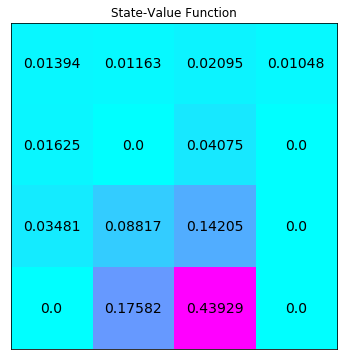

In [16]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

运行以下代码单元格以测试你的函数。如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！ 

**注意：**为了确保结果准确，确保 `policy_iteratio` 函数满足上文列出的要求（具有三个输入、两个输出，并且没有更改输入参数的默认值）。

In [17]:
check_test.run_check('policy_iteration_check', policy_iteration)

/home/workspace/check_test.py:18: RuntimeWarning: overflow encountered in double_scalars
  Vs += action_prob * prob * (reward + gamma * V[next_state])
/home/workspace/check_test.py:19: RuntimeWarning: invalid value encountered in double_scalars
  delta = max(delta, np.abs(V[s]-Vs))
/home/workspace/check_test.py:19: RuntimeWarning: invalid value encountered in absolute
  delta = max(delta, np.abs(V[s]-Vs))


**<span style="color: red;">PLEASE TRY AGAIN</span>**

### 第 5 部分：截断策略迭代

在此部分，你将自己编写截断策略迭代的实现。  

首先，你将实现截断策略评估。你的算法应该有五个**输入**参数：
- `env`：这是 OpenAI Gym 环境的实例，其中 `env.P` 会返回一步动态特性。
- `policy`：这是一个二维 numpy 数组，其中 `policy.shape[0]` 等于状态数量 (`env.nS`) ， `policy.shape[1]` 等于动作数量 (`env.nA`) 。`policy[s][a]`  返回智能体在状态 `s` 时根据该策略选择动作 `a` 的概率。
- `V`：这是一个一维 numpy 数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 的估值。
- `max_it`：这是一个正整数，对应的是经历状态空间的次数（默认值为：`1`）。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下**输出结果**：
- `V`：这是一个一维 numpy 数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 的估值。

请完成以下代码单元格中的函数。

In [ ]:
def truncated_policy_evaluation(env, policy, V, max_it=1, gamma=1):
    
    ## TODO: complete the function
    
    return V

接着，你将实现截断策略迭代。你的算法应该接受四个**输入**参数：
- `env`：这是 OpenAI Gym 环境的实例，其中 `env.P` 会返回一步动态特性。
- `max_it`：这是一个正整数，对应的是经历状态空间的次数（默认值为：`1`）。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。
- `theta`：这是一个非常小的正整数，用作停止条件（默认值为：`1e-8`）。

该算法会返回以下**输出结果**：
- `policy`：这是一个二维 numpy 数组，其中 `policy.shape[0]` 等于状态数量 (`env.nS`) ， `policy.shape[1]` 等于动作数量 (`env.nA`) 。`policy[s][a]`  返回智能体在状态 `s` 时根据该策略选择动作 `a` 的概率。
- `V`：这是一个一维 numpy 数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 的估值。

请完成以下代码单元格中的函数。

In [ ]:
def truncated_policy_iteration(env, max_it=1, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA]) / env.nA
    
    ## TODO: complete the function
    
    return policy, V

运行下个代码单元格以解决该 MDP 并可视化输出结果。状态值函数已调整形状，以匹配网格世界的形状。

请实验不同的 `max_it` 参数值。始终都能获得最优状态值函数吗？

In [ ]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_it=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_tpi,"\n")

# plot the optimal state-value function
plot_values(V_tpi)

运行以下代码单元格以测试你的函数。如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！ 

**注意：**为了确保结果准确，确保 `truncated_policy_iteration` 函数满足上文列出的要求（具有四个输入、两个输出，并且没有更改输入参数的默认值）。

In [ ]:
check_test.run_check('truncated_policy_iteration_check', truncated_policy_iteration)

### 第 6 部分：值迭代

在此部分，你将自己编写值迭代的实现。

你的算法应该接受三个输入参数：
- `env`：这是 OpenAI Gym 环境的实例，其中 `env.P` 会返回一步动态特性。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。 
- `theta`：这是一个非常小的正整数，用作停止条件（默认值为：`1e-8`）。

该算法会返回以下**输出结果**：
- `policy`：这是一个二维 numpy 数组，其中 `policy.shape[0]` 等于状态数量 (`env.nS`) ， `policy.shape[1]` 等于动作数量 (`env.nA`) 。`policy[s][a]`  返回智能体在状态 `s` 时根据该策略选择动作 `a` 的概率。
- `V`：这是一个一维 numpy 数组，其中 `V.shape[0]` 等于状态数量 (`env.nS`)。`V[s]` 包含状态 `s` 的估值。

In [ ]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    
    ## TODO: complete the function
    
    return policy, V

运行下个代码单元格以解决该 MDP 并可视化输出结果。状态值函数已调整形状，以匹配网格世界的形状。

In [ ]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)

运行以下代码单元格以测试你的函数。如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！ 

**注意：**为了确保结果准确，确保 `truncated_policy_iteration` 函数满足上文列出的要求（具有三个输入、两个输出，并且没有更改输入参数的默认值）。

In [ ]:
check_test.run_check('value_iteration_check', value_iteration)